In [6]:
%pip install -qU langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install langchain

In [8]:
!pip install cdlib

In [9]:
!pip install pymupdf

In [10]:
# Install required packages
!pip install ollama pandas networkx matplotlib tqdm -q

In [11]:
# Install Ollama
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sh' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# Importing all the necessary libraries
import fitz
import json
import os
import threading
import subprocess
from langchain.text_splitter import RecursiveCharacterTextSplitter
import ollama
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pandas as pd
from cdlib import algorithms
import numpy as np

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [2]:
%cd C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment

C:\Users\trifo\Desktop\GitHub Clone\NLP_Assignment


Data Processing with LLMs

Implement local or cloud-based Large Language Models (LLMs) to:





*   Extract and structure relevant market data
*   Identify network relationships between entities
*   Perform named entity recognition and extraction
*   Transform unstructured text into analyzable formats





In [3]:
# Define the path to the PDF file in Google Drive
pdf_document = 'C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/file.pdf'


# Open the PDF
doc = fitz.open(pdf_document)

# Extract text from each page
full_text = ""  # Initialize a string to store the entire text

for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text = page.get_text("text")  # Extract text from the page
    full_text += text  # Append the text to the full_text variable
    print(f"Page {page_num + 1}:\n{text}")  # Print each page's text


Page 1:
GADGET
Written by
Christopher Nolan
Based on the novel:
"American Prometheus:
The Triumph and Tragedy of J. Robert Oppenheimer"
By
Kai Bird and Martin J. Sherwin
© 2022 SYNCOPY

Page 2:
Gadget     2023-04-21       FINAL Shooting Script
1.
A VAST SPHERE OF FIRE, the fire of a thousand suns, slowly 
eats the night-time desert. A line of black type appears:
PROMETHEUS STOLE FIRE FROM THE GODS AND GAVE IT TO MAN.
And the sound of DOZENS OF FEET STAMPING RHYTHMICALLY...
FOR THIS HE WAS CHAINED TO A ROCK AND TORTURED FOR ETERNITY.
ROILING PLASMA expands, the sound of STAMPING GROWS 
OPPRESSIVE, the STAMPING FASTER and FASTER OVER-
A FACE. Gaunt, tense, EYES TIGHTLY SHUT. The face SHUDDERS- 
the sound CEASES AS MY EYES OPEN, STARING INTO THE CAMERA:
Peer into my soul- J. ROBERT OPPENHEIMER, aged fifty, close-
cropped greying hair. The gentle sounds of bureaucracy...
SUPER TITLE: "1. FISSION"
VOICE (O.S.)
Dr Oppenheimer, as we begin, I 
believe you have a statement to 
read into the re

In [4]:
# Set up your chunk size and overlap
chunk_size = 2000
chunk_overlap = 300  # Slight overlap to maintain context across chunks

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Split the text into chunks
chunks = text_splitter.split_text(full_text)

# Display the first few chunks to verify the split
for i, chunk in enumerate(chunks[:5]):
    print(f"Chunk {i+1}:\n{chunk}\n")
    print("="*50)


Chunk 1:
GADGET
Written by
Christopher Nolan
Based on the novel:
"American Prometheus:
The Triumph and Tragedy of J. Robert Oppenheimer"
By
Kai Bird and Martin J. Sherwin
© 2022 SYNCOPY
Gadget     2023-04-21       FINAL Shooting Script
1.
A VAST SPHERE OF FIRE, the fire of a thousand suns, slowly 
eats the night-time desert. A line of black type appears:
PROMETHEUS STOLE FIRE FROM THE GODS AND GAVE IT TO MAN.
And the sound of DOZENS OF FEET STAMPING RHYTHMICALLY...
FOR THIS HE WAS CHAINED TO A ROCK AND TORTURED FOR ETERNITY.
ROILING PLASMA expands, the sound of STAMPING GROWS 
OPPRESSIVE, the STAMPING FASTER and FASTER OVER-
A FACE. Gaunt, tense, EYES TIGHTLY SHUT. The face SHUDDERS- 
the sound CEASES AS MY EYES OPEN, STARING INTO THE CAMERA:
Peer into my soul- J. ROBERT OPPENHEIMER, aged fifty, close-
cropped greying hair. The gentle sounds of bureaucracy...
SUPER TITLE: "1. FISSION"
VOICE (O.S.)
Dr Oppenheimer, as we begin, I 
believe you have a statement to 
read into the record?
I 

In [5]:
# Sets up environment variables and starts the Ollama server

import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [17]:
#download a model
!ollama run qwen2.5

^C


In [18]:
# Sets up environment variables and starts the Ollama server

import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [6]:
SYSTEM_PROMPT = """
Extract interactions between characters from the given movie script. For each interaction, identify the characters involved,relevant country that the interaction took place, describe the nature of their relationship using a limited set of relationship types, classify the interaction into a relevant theme, and determine the overall sentiment as either "positive" or "negative." Structure the output in JSON format as follows:

{
 "edges": [
   {"from": "Character Name 1", "to": "Character Name 2", "place": "country_name", "type": "interaction_type", "theme_type": "Theme Category", "sentiment": "Sentiment"}
 ]
}

Field Descriptions:
- **from**: Name of the first character in the interaction.
- **to**: Name of the second character in the interaction.
- **type**: Choose one of these predefined relationship types:
   - "Romantic Relationship"
   - "Professional Mentorship"
   - "Personal Conflict"
   - "Intellectual Collaboration"
   - "Political Rivalry"
   - "Support"
   - "Admiration"
   - "Betrayal"
   - "Family Loyalty"
-- **place**:Choose only one of these predefined country places, nothing else:
   -"Los Alamos, USA"
   -"Berkeley, USA"
   -"Washington D.C., USA"
   -"Trinity Test Site, USA"
   -"Princeton, USA"
   -"Chicago, USA"
   -"New York, USA"
   -"San Francisco, USA"
   -"Santa Fe, USA"
   -"Pasadena, USA"
   -"New Mexico, USA"
   -"Youngstown, USA"
   -"Colorado, USA"
   -"Tennessee, USA"
   -"Zurich, Switzerland"
   -"Cambridge, UK"
   -"Copenhagen, Denmark"
   -"Germany, Germany"
   -"England, England"








- **theme_type**: Select the most relevant theme from this streamlined list:
   1. Love and Romance
   2. Betrayal and Conflict
   3. Friendship and Loyalty
   4. Ambition and Power
   5. Justice and Injustice

- **sentiment**: Assign either "positive" or "negative" based on the overall tone of the interaction:
   - Use "positive" for interactions that reflect support, admiration, loyalty, or constructive collaboration.
   - Use "negative" for interactions that involve conflict, betrayal, rivalry, or animosity.

Requirements:
- Exclude minor or ambiguous entities that do not contribute to primary character relationships.
- Focus only on **meaningful interactions** that provide insight into character relationships or significant themes.
- **English output only**.
- Each entry should represent a **single interaction between two characters** only. Separate entries for each pair if there are multiple interactions in a single context.
- Avoid redundant relationships: Only include multiple entries for the same characters if the context or theme differs significantly.

Examples:
1. {"from": "Oppenheimer", "to": "Kitty", "place": "England, England", "type": "romantic relationship", "theme_type": "Love and Romance", "sentiment": "positive"}
2. {"from": "Oppenheimer", "to": "Strauss", "place": "Cambridge, UK","type": "political rivalry", "theme_type": "Ambition and Power", "sentiment": "negative"}
3. {"from": "Rabi", "to": "Oppenheimer","place": "New Mexico, USA", "type": "support", "theme_type": "Friendship and Loyalty", "sentiment": "positive"}
4. {"from": "Kitty", "to": "Frank","place": "Pasadena, USA","type": "support", "theme_type": "Friendship and Loyalty", "sentiment": "positive"}
5. {"from": "Alvarez", "to": "Lawrence","place": "San Francisco, USA", "type": "professional mentorship", "theme_type": "Ambition and Power", "sentiment": "positive"}

Output Quality Tips:
- Use the specific relationship types listed above to maintain consistency.
- Select the theme that best represents the overall context of the interaction, avoiding overly broad or mismatched themes.
- Assign sentiment based on the tone of the interaction, using "positive" for constructive and "negative" for adversarial interactions.

Ensure that the final output is clear, concise, and uses only the specified relationship types, themes, and sentiment labels.
"""

# Extracting Relationships
We'll create a function to process each article and extract the relationships:

In [7]:
def extract_relationships(text_chunk, chunk_id):
    # Create the prompt using the chunk ID for context
    prompt = f"""
    Extract key relationships between characters and events from this text:
    Chunk ID: {chunk_id}
    Text: {text_chunk}
    """

    # Send the prompt to the LLM
    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        format='json',  # Expecting a JSON format output
        options={"temperature": 0.1}  # Low temperature for deterministic results
    )

    # Parse the response content as JSON
    try:
        relationships = json.loads(response['message']['content'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for Chunk {chunk_id}")
        return None

    # Return the parsed JSON object
    return relationships

In [9]:
# Initialize a list to store all relationships
all_relationships = []

# Process each chunk
for i, chunk in enumerate(chunks):
    # Extract relationships from the current chunk
    relationships = extract_relationships(chunk, chunk_id=i+1)

    # Check and aggregate the results
    if relationships:
        print(f"Extracted Relationships from Chunk {i+1}:")
        print(relationships)
        all_relationships.extend(relationships['edges']) 

# Final output with all relationships
if all_relationships:
    print("\nAll Extracted Relationships:")
    for relationship in all_relationships:
        print(relationship)
else:
    print("No relationships found in any chunk.")


Extracted Relationships from Chunk 1:
{'edges': [{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Justice and Injustice', 'sentiment': 'negative'}, {'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}]}
Extracted Relationships from Chunk 2:
{'edges': [{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}, {'from': 'Strauss', 'to': 'Thurmond', 'place': 'Washington D.C., USA', 'type': 'Political Rivalry', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}]}
Extracted Relationships from Chunk 3:
{'edges': [{'from': 'Oppenheimer', 'to': 'Blackett', 'place': 'Cambridge, UK', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 

In [10]:
# Save all relationships to a JSON file in Google Colab
with open("C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/extracted_relationships.json", "w") as f:
    json.dump(all_relationships, f, indent=2)

print("File saved as extracted_relationships.json locally.")


File saved as extracted_relationships.json locally.


# Network Analysis


*   In this section, we will perform network analysis to better understand the relationships between characters.
*   We'll begin by loading the extracted data, cleaning it to remove duplicates, and standardizing character names.
*   Then, we'll use NetworkX to create a graph of character interactions, visualize the network, and analyze important metrics.
*   These metrics include degree centrality, betweenness centrality, and closeness centrality to identify key characters.
*   Finally, we'll detect communities within the network to reveal clusters of characters with stronger relationships.








In [11]:
# Load the JSON file
with open('C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/extracted_relationships.json', 'r') as file:
    data = json.load(file)

# Preview the first few entries in the list
print("First few entries in the data:")
for edge in data[:5]:
    print(edge)


First few entries in the data:
{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Justice and Injustice', 'sentiment': 'negative'}
{'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}
{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}
{'from': 'Strauss', 'to': 'Thurmond', 'place': 'Washington D.C., USA', 'type': 'Political Rivalry', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}
{'from': 'Oppenheimer', 'to': 'Blackett', 'place': 'Cambridge, UK', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}


In [12]:
# Collect unique character names from 'from' and 'to' fields
unique_characters = set()

for edge in data:
    unique_characters.add(edge['from'])
    unique_characters.add(edge['to'])

# Display all unique character names in a list
print("All unique characters:")
for character in unique_characters:
    print(character)


All unique characters:
Bethe
Volpe
Weatherman
Fermi
Alvarez
Pastore
Kennedy
Oppenheimer
Lomanitz
Chevalier
Kistiakowsky
Glasses
Senate Aide (V.O.)
Power Brokers in Washington
Jackie
Pash
Concerned Scientist
Senator Aide
Nichols
Byrnes
EVANS
Hill
Strauss
Bush
GROVES
Condron
Marshall
Second Voice (O.S.)
Truman
Senate Aide
Senator Bartlett
McGee
Rabi
Gray
Guard
Stimson
Snyder
Chairman
Lawrence
Young Oppenheimer
Gödel
Serber
Kitty
Crowd
Bohr
Wilkins
Tolman
Johnson
Frank
Donald
Barbara
Hornig
Dr Bush
Feynman
Fuchs
Borden
Groves
Aide
Gadget (Narrator)
Einstein
Counsel
Teller
Joe Dallet
FBI
Thurmond
Blackett
TRUMAN
Robb
Ruth
New Mexico
Young Woman
Condon
Bainbridge
Morrison
Szilard
Garrison
Ruth Tolman
Heisenberg
Tatlock
Germany
Neddermeyer


In [13]:
# Collect unique place names
unique_places = set()

for edge in data:
    unique_places.add(edge['place'])

# Display all unique place names in a list
print("All unique places:")
for place in unique_places:
    print(place)


All unique places:

The White House, USA
Youngstown, USA
Corridor outside Room 2022, USA
Snowy Woods, Los Alamos
Office, University of Michigan, USA
Atomic Energy Commission, Washington D.C., USA
Desert, Los Alamos, USA
Plaza Hotel, USA
Atomic Energy Commission - Day
Hotel Room 805, San Francisco, USA
New Mexico, USA
President's Dining Hall, Berkeley, USA
Room 805, Hotel, San Francisco
Strauss Residence, Washington D.C., USA
Canyon, Los Alamos, USA
Harvard, USA
Los Alamos, USA
Copenhagen, Denmark
Train, Santa Fe to Chicago, USA
Trinity Test Site, USA
Cambridge, UK
New York, USA
Cambridge, USA
Santa Fe to Chicago, USA
Chevalier House, New Mexico, USA
Oval Office, The White House, USA
Washington D.C., USA
Corridor, MIT, USA
Strauss House, USA
Base Camp, Trinity Test Site, USA
Quadrangle, Princeton, USA
Senate Office, USA
Santa Fe, USA
South Observation Post, USA
Pasadena, USA
Chicago, USA
Berkeley, USA
Room 2022, Atomic Energy Commission, USA
INT. ROOM 2022, ATOMIC ENERGY COMMISSION -- D

In [14]:
# Collect unique themes of interaction
unique_themes = set()

for edge in data:
    unique_themes.add(edge['theme_type'])

# Display all unique themes in a list
print("All unique themes:")
for theme in unique_themes:
    print(theme)

All unique themes:
Justice and Injustice
Betrayal and Conflict
Love and Romance
Ambition and Power
Knowledge Sharing
Knowledge and Discovery
Friendship and Loyalty


In [15]:
# Collect unique relationships
unique_relationships = set()

for edge in data:
    unique_relationships.add(edge['type'])

# Display all unique relationships in a list
print("All unique relationships:")
for relationship in unique_relationships:
    print(relationship)

All unique relationships:
Family Loyalty
political rivalry
Romantic Relationship
Suspicions
support
Professional Mentorship
Betrayal and Conflict
romantic relationship
personal connection
Professional Conflict
Betrayal
personal conflict
Professional Collaboration
Intellectual Collaboration
Personal Conflict
Support
Political Rivalry
intellectual collaboration
professional collaboration
professional mentorship


In [16]:
# Define the mapping for character name standardization
name_mapping = {
    'Niels Bohr': 'Bohr',
    'Strauss (implied)': 'Strauss',
    'McGee (Senator)': 'Senator McGee',
    'GROVES': 'Groves',
    'Dr Bush': 'Bush',
    'BUSH': 'Bush',
    'Kitty Oppenheimer': 'Kitty',
    'Kitty (V.O.)':'Kitty',
    'Senate Aide (V.O.)': 'Senate Aide',
    'Young Oppenheimer':'Oppenheimer',
    'Groves (V.O.)':'Groves',
}

# Names to remove as generic
generic_names = {"Young Woman", 'Young Man', "Los Alamos Community","Crowd","I", "Young People", "Second Voice (O.S.)", "Concerned Scientist", "Unspecified",  "Germany", "America", "Pacific Conflict", "Oppenheimer'S Enemies", 'Counsel','Voice (O.S.)','Rabi, Lawrence, Frank, Jackie'}

# Apply the mapping, title case, and combine/remove entries
standardized_data = []

for edge in data:
    # Apply name mapping and convert to title case
    edge['from'] = name_mapping.get(edge['from'], edge['from']).title()
    edge['to'] = name_mapping.get(edge['to'], edge['to']).title()

    # Skip edges with generic names
    if edge['from'] not in generic_names and edge['to'] not in generic_names:
        standardized_data.append(edge)


In [17]:
# Count occurrences of each character in the standardized data
character_counts = Counter()
for edge in standardized_data:
    character_counts[edge['from']] += 1
    character_counts[edge['to']] += 1

# Sort the character counts from highest to lowest
sorted_character_counts = sorted(character_counts.items(), key=lambda x: x[1], reverse=True)

# Display updated unique character counts in sorted order
print("Updated unique characters and counts (sorted from highest to lowest):")
for character, count in sorted_character_counts:
    print(f"{character}: {count}")

Updated unique characters and counts (sorted from highest to lowest):
Oppenheimer: 276
Strauss: 74
Groves: 51
Kitty: 40
Robb: 25
Rabi: 20
Lawrence: 19
Teller: 18
Garrison: 17
Einstein: 13
Frank: 13
Bohr: 12
Tatlock: 11
Bush: 11
Borden: 11
Serber: 10
Pash: 10
Hill: 10
Nichols: 9
Kistiakowsky: 9
Chevalier: 7
Senate Aide: 6
Feynman: 6
Bethe: 6
Lomanitz: 5
Truman: 5
Stimson: 5
Bainbridge: 4
Condon: 4
Szilard: 4
Heisenberg: 3
Snyder: 3
Tolman: 3
Fuchs: 3
Fermi: 3
Volpe: 3
Blackett: 2
Ruth Tolman: 2
Glasses: 2
Hornig: 2
Johnson: 2
Ruth: 2
Morrison: 2
Byrnes: 2
Gray: 2
Thurmond: 1
New Mexico: 1
Senator Bartlett: 1
Jackie: 1
Alvarez: 1
Joe Dallet: 1
Senator Aide: 1
Fbi: 1
Power Brokers In Washington: 1
Gadget (Narrator): 1
Donald: 1
Condron: 1
Gödel: 1
Barbara: 1
Wilkins: 1
Neddermeyer: 1
Guard: 1
Mcgee: 1
Marshall: 1
Weatherman: 1
Aide: 1
Chairman: 1
Pastore: 1
Evans: 1
Kennedy: 1


In [18]:
# Standardize capitalization
for edge in standardized_data:
    edge['type'] = edge['type'].title()  
    edge['theme_type'] = edge['theme_type'].title()  
    edge['sentiment'] = edge['sentiment'].capitalize() 
    edge['place'] = edge['place'].title()

In [19]:
from logging import PlaceHolder
# Define mappings for relationship types and themes to consolidate variations
type_mapping = {
    "Authority Figure": "Professional Mentorship",
    "Advice": "Support",
    "Suspected Betrayal": "Betrayal",
    "Betrayal And Conflict": "Betrayal",
}



# Apply mappings to standardize data
for edge in standardized_data:
    edge['type'] = type_mapping.get(edge['type'], edge['type'])

In [20]:
# Re-run counts after consolidation
relationship_type_counts = Counter(edge['type'] for edge in standardized_data)
print("Unique Relationship Types and Counts After Consolidation:")
for relationship, count in sorted(relationship_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{relationship}: {count}")

print("\n" + "="*40 + "\n")

theme_type_counts = Counter(edge['theme_type'] for edge in standardized_data)
print("Unique Theme Types and Counts After Consolidation:")
for theme, count in sorted(theme_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{theme}: {count}")

print("\n" + "="*40 + "\n")

place_counts = Counter(edge['place'] for edge in standardized_data)
print("Unique Places:")
for place, count in sorted(place_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{place}: {count}")

print("\n" + "="*40 + "\n")

sentiment_counts = Counter(edge['sentiment'] for edge in standardized_data)

print("Unique Sentiment Types and Counts:")
for sentiment, count in sorted(sentiment_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{sentiment}: {count}")

Unique Relationship Types and Counts After Consolidation:
Professional Mentorship: 153
Intellectual Collaboration: 69
Support: 50
Personal Conflict: 50
Political Rivalry: 39
Romantic Relationship: 11
Betrayal: 4
Family Loyalty: 3
Professional Collaboration: 3
Professional Conflict: 2
Personal Connection: 1
Suspicions: 1


Unique Theme Types and Counts After Consolidation:
Ambition And Power: 210
Betrayal And Conflict: 76
Friendship And Loyalty: 61
Justice And Injustice: 19
Love And Romance: 18
Knowledge And Discovery: 1
Knowledge Sharing: 1


Unique Places:
Washington D.C., Usa: 79
Los Alamos, Usa: 78
Berkeley, Usa: 43
New Mexico, Usa: 24
Trinity Test Site, Usa: 22
Princeton, Usa: 18
Pasadena, Usa: 18
Chicago, Usa: 10
: 9
New York, Usa: 7
Room 2022, Atomic Energy Commission, Usa: 7
Zurich, Switzerland: 5
Int. Room 2022, Atomic Energy Commission -- Day (Colour): 5
Santa Fe, Usa: 4
Olden Manor, Princeton: 4
Cambridge, Uk: 3
Cambridge, Usa: 3
Corridor, Mit, Usa: 3
Train, Santa Fe To Chica

In [30]:
#print standarized data nodes and edges
# Preview the first few entries in the list
print("First few entries in the data:")
for edge in standardized_data[:20]:
    print(edge)

First few entries in the data:
{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., Usa', 'type': 'Professional Mentorship', 'theme_type': 'Ambition And Power', 'sentiment': 'Neutral'}
{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., Usa', 'type': 'Professional Mentorship', 'theme_type': 'Ambition And Power', 'sentiment': 'Positive'}
{'from': 'Strauss', 'to': 'Thurmond', 'place': 'Washington D.C., Usa', 'type': 'Political Rivalry', 'theme_type': 'Betrayal And Conflict', 'sentiment': 'Negative'}
{'from': 'Oppenheimer', 'to': 'Blackett', 'place': 'Cambridge, Uk', 'type': 'Professional Mentorship', 'theme_type': 'Ambition And Power', 'sentiment': 'Negative'}
{'from': 'Oppenheimer', 'to': 'Bohr', 'place': 'Cambridge, Uk', 'type': 'Intellectual Collaboration', 'theme_type': 'Love And Romance', 'sentiment': 'Positive'}
{'from': 'Oppenheimer', 'to': 'Strauss', 'place': 'Princeton, Usa', 'type': 'Professional Mentorship', 'theme_type': 'Ambition And Power', 's

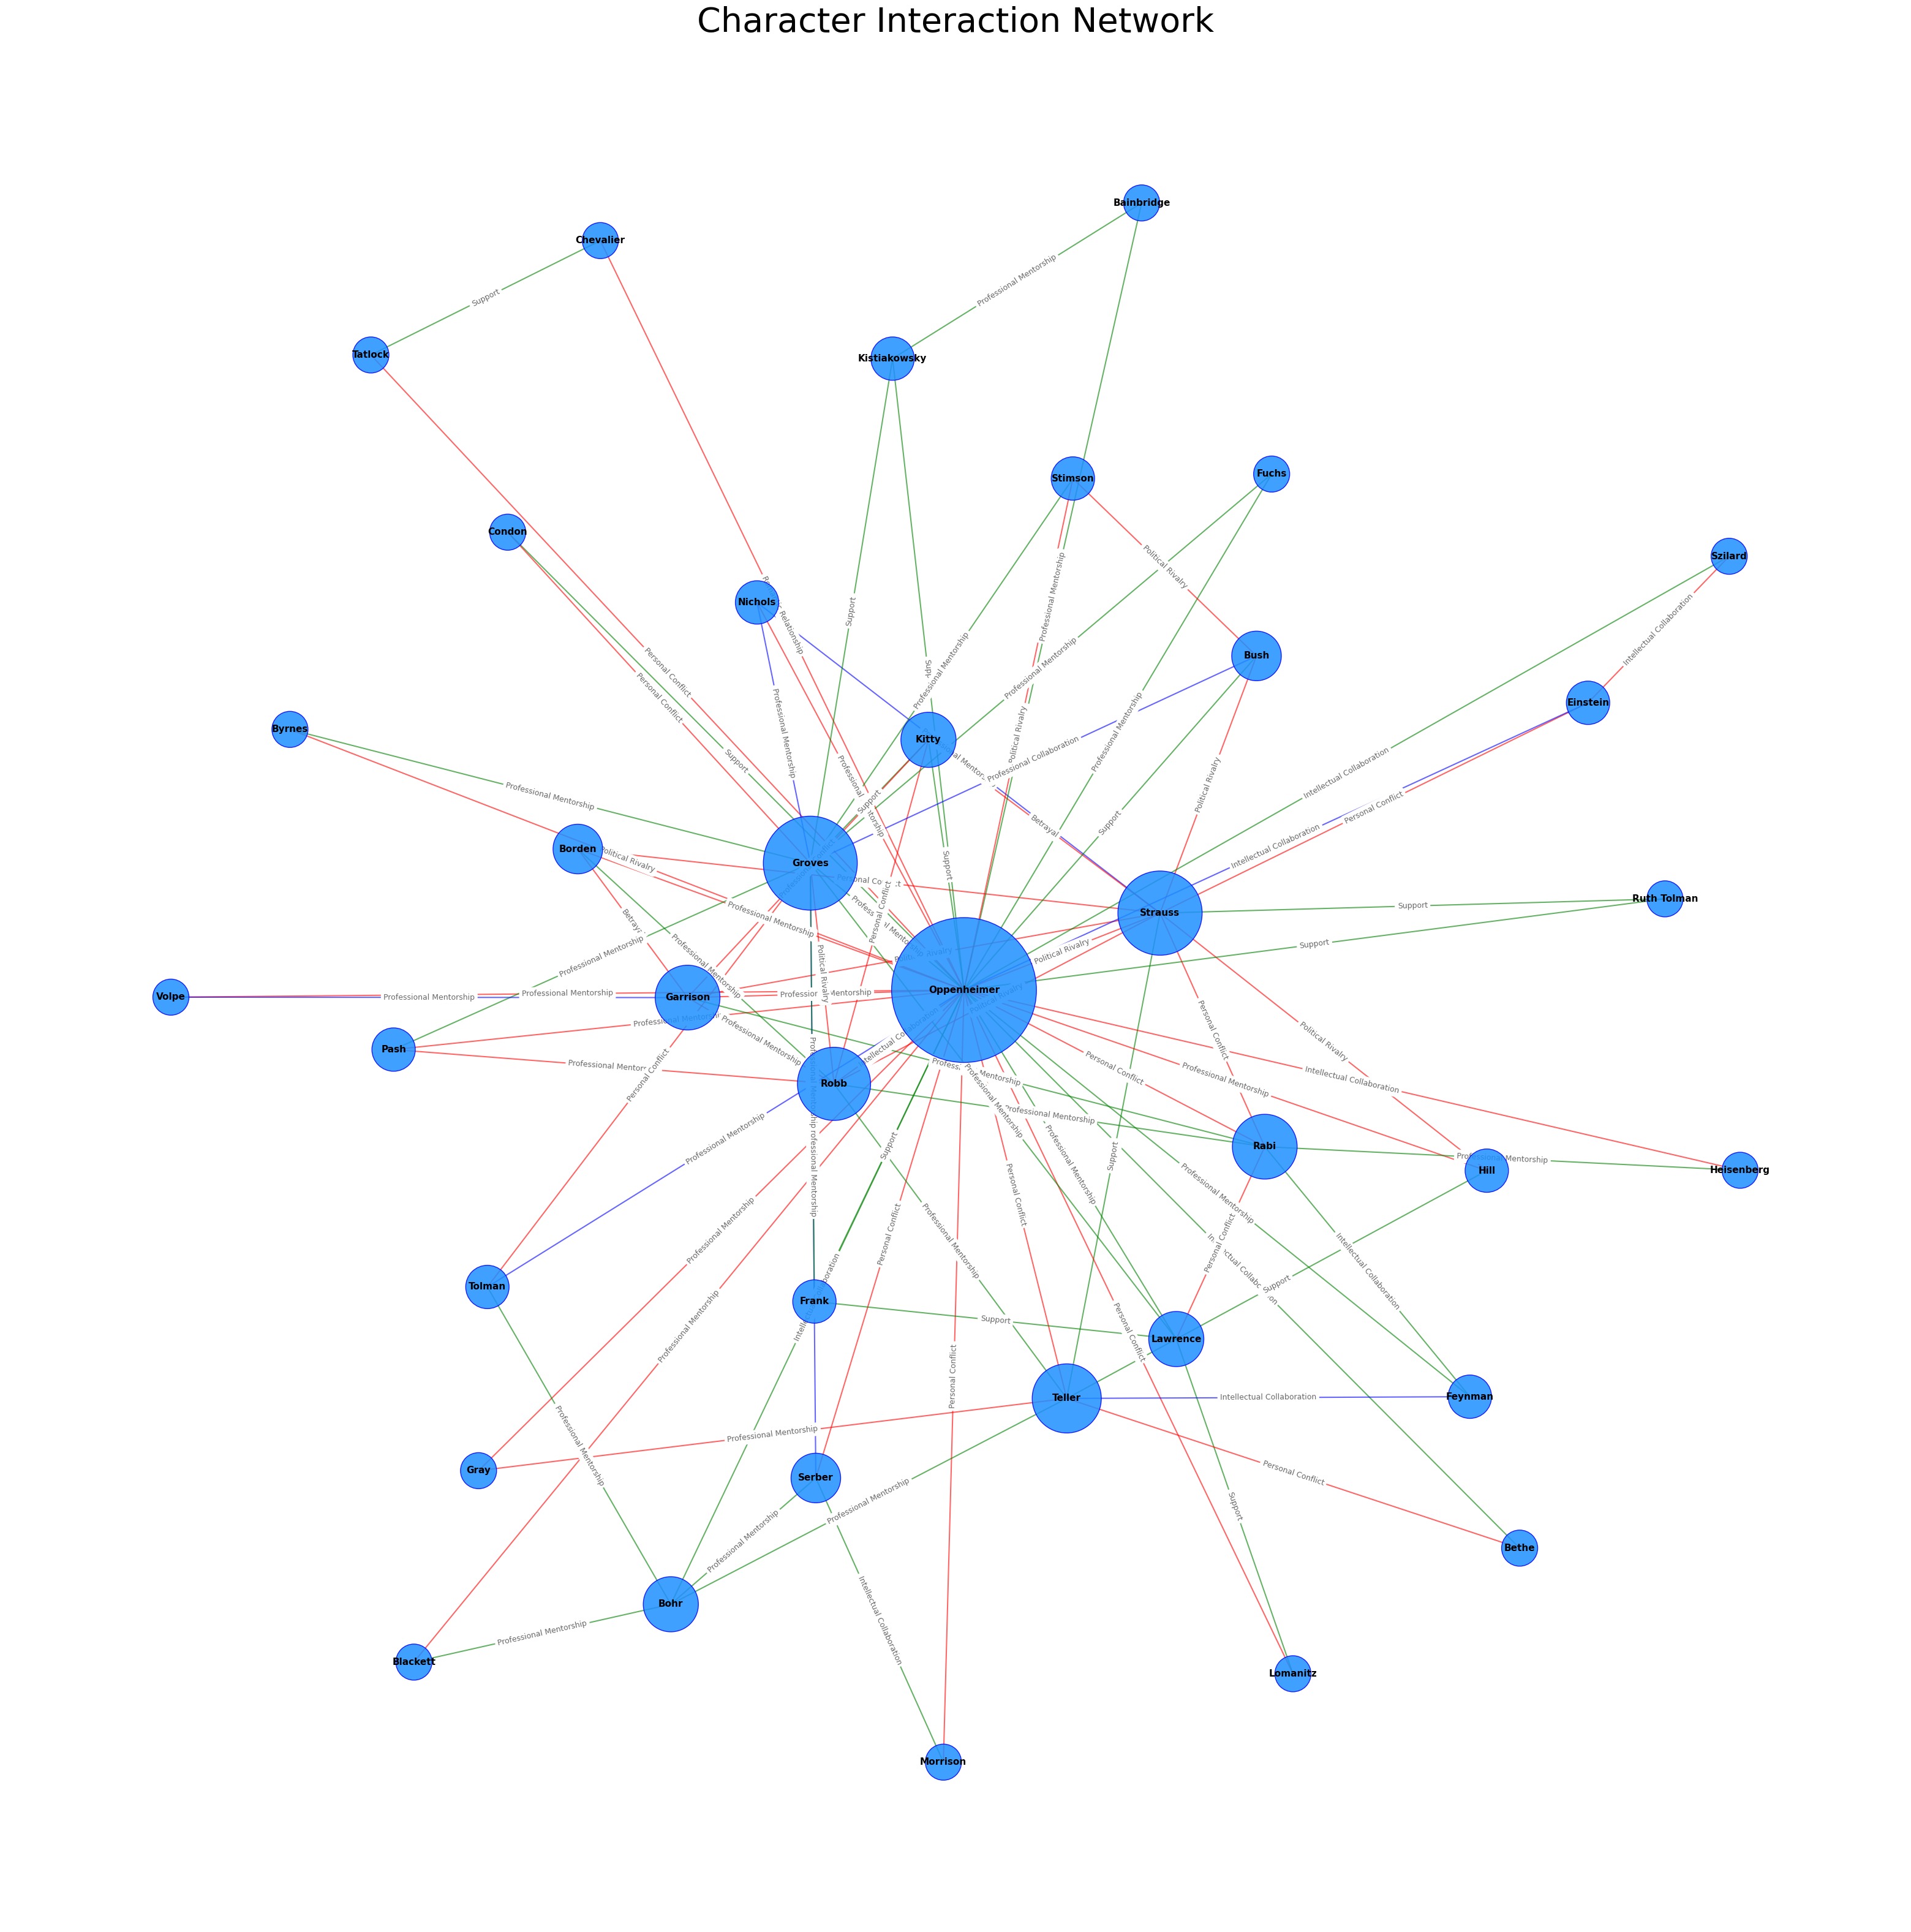

In [28]:
# Create a graph
G = nx.Graph()

# Add edges to the graph, filtering out self-loops
for edge in standardized_data:
    from_character = edge['from']
    to_character = edge['to']
    relationship_type = edge['type']
    theme_type = edge['theme_type']
    sentiment = edge['sentiment']  
    place= edge['place']

    # Only add edges where from_character and to_character are different
    if from_character != to_character:
        G.add_edge(from_character, to_character, type=relationship_type, theme_type=theme_type, sentiment=sentiment)

# Remove nodes with only one connection (degree of 1)
nodes_to_remove = [node for node, degree in G.degree() if degree == 1]
G.remove_nodes_from(nodes_to_remove)

# Calculate node sizes based on degree centrality for the remaining graph
node_sizes = [200 + 800 * nx.degree(G, n) for n in G.nodes()]  # Adjust multiplier for visibility

# Prepare edge colors based on sentiment
edge_colors = [
    'green' if G[u][v]['sentiment'] == 'Positive' else 
    'red' if G[u][v]['sentiment'] == 'Negative' else 
    'blue' 
    for u, v in G.edges()
]

# Plotting the network
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes with customized size and color
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='dodgerblue', edgecolors='blue', alpha=0.85)

nx.draw_networkx_edges(
    G, pos,
    width=1.5,
    alpha=0.6,
    edge_color=edge_colors
)

# Draw labels for nodes with increased font size
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# Add edge labels for relationship types

edge_labels = nx.get_edge_attributes(G, 'type')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=9,
    font_color="dimgray"
)

plt.title("Character Interaction Network", fontsize=40)
plt.axis("off")
plt.show()


In [22]:
# Calculate graph metrics: density, average degree, total nodes, and total edges

# Density of the graph
density = nx.density(G)

# Total number of nodes in the graph
total_nodes = G.number_of_nodes()

# Total number of edges in the graph
total_edges = G.number_of_edges()

# Calculate average degree (sum of degrees of all nodes divided by the total number of nodes)
average_degree = sum(dict(G.degree()).values()) / total_nodes

# Display graph metrics
print(f"Graph Density: {density:.4f}")
print(f"Total Number of Nodes: {total_nodes}")
print(f"Total Number of Edges: {total_edges}")
print(f"Average Degree: {average_degree:.2f}")

Graph Density: 0.1336
Total Number of Nodes: 37
Total Number of Edges: 89
Average Degree: 4.81


Graph Density: 0.0574

Explanation: Graph density measures the ratio of actual edges to the maximum possible edges in a graph. It provides insight into how densely connected the network is.
Interpretation: A density of 0.0574 means that only about 5.74% of all possible edges between nodes are present. This indicates a relatively sparse network, where most nodes are not directly connected to many other nodes.
Total Number of Nodes: 67

Explanation: This represents the total number of nodes (or vertices) in the graph.
Interpretation: The graph contains 67 unique entities, which could represent individuals, objects, or any entities being connected in this network.
Total Number of Edges: 127

Explanation: This is the total number of edges (connections) between nodes in the graph.
Interpretation: There are 127 connections among the 67 nodes. Each edge represents a relationship or interaction between two nodes.
Average Degree: 3.79

Explanation: The average degree is the average number of connections (edges) per node. It’s calculated as the total number of edges divided by the number of nodes.
Interpretation: On average, each node has about 3.79 connections. This provides insight into the level of connectivity within the network, showing that nodes tend to have a few connections rather than being highly interconnected.

In [23]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create a summary of centrality measures
centrality_summary = {
    "Character": [],
    "Degree Centrality": [],
    "Betweenness Centrality": [],
    "Eigenvector Centrality": []
}

for character in G.nodes():
    centrality_summary["Character"].append(character)
    centrality_summary["Degree Centrality"].append(degree_centrality[character])
    centrality_summary["Betweenness Centrality"].append(betweenness_centrality[character])
    centrality_summary["Eigenvector Centrality"].append(eigenvector_centrality[character])

# Convert to a DataFrame for better display
centrality_df = pd.DataFrame(centrality_summary)

# Sort the DataFrame by Degree Centrality and get the top 10
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False).head(10)

# Display the top 10 in a nicely formatted table
print(centrality_df.to_string(index=False))

  Character  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
Oppenheimer           1.000000                0.762487                0.546654
     Groves           0.416667                0.066931                0.285604
    Strauss           0.333333                0.032540                0.275380
       Robb           0.250000                0.010635                0.255690
     Teller           0.222222                0.014286                0.190529
   Garrison           0.194444                0.005159                0.200960
       Rabi           0.194444                0.008730                0.192166
       Bohr           0.138889                0.004497                0.124816
   Lawrence           0.138889                0.003704                0.144865
      Kitty           0.138889                0.000847                0.185411


### Centrality Measures Analysis

This table summarizes the centrality measures for the top characters in the interaction network:

- `Degree Centrality` indicates how well-connected each character is, with Oppenheimer being the most central figure.
- `Betweenness Centrality`measures the extent to which a character lies on paths between others, highlighting Oppenheimer's major influence and Strauss' intermediary role.
- `Eigenvector Centrality` ranks Oppenheimer highest, suggesting his importance is not only due to direct connections but also because he is connected to other influential characters, with Groves and Strauss also having substantial influence within the network.


# Community Detection

- In this section, we apply community detection to the character interaction network to identify clusters of closely connected characters.
- Using the Louvain algorithm, we detect distinct communities in the graph, which can reveal groups of characters that interact more frequently.
- We then visualize the network with each node colored according to its community, providing insights into the structure and relationships within the character network.

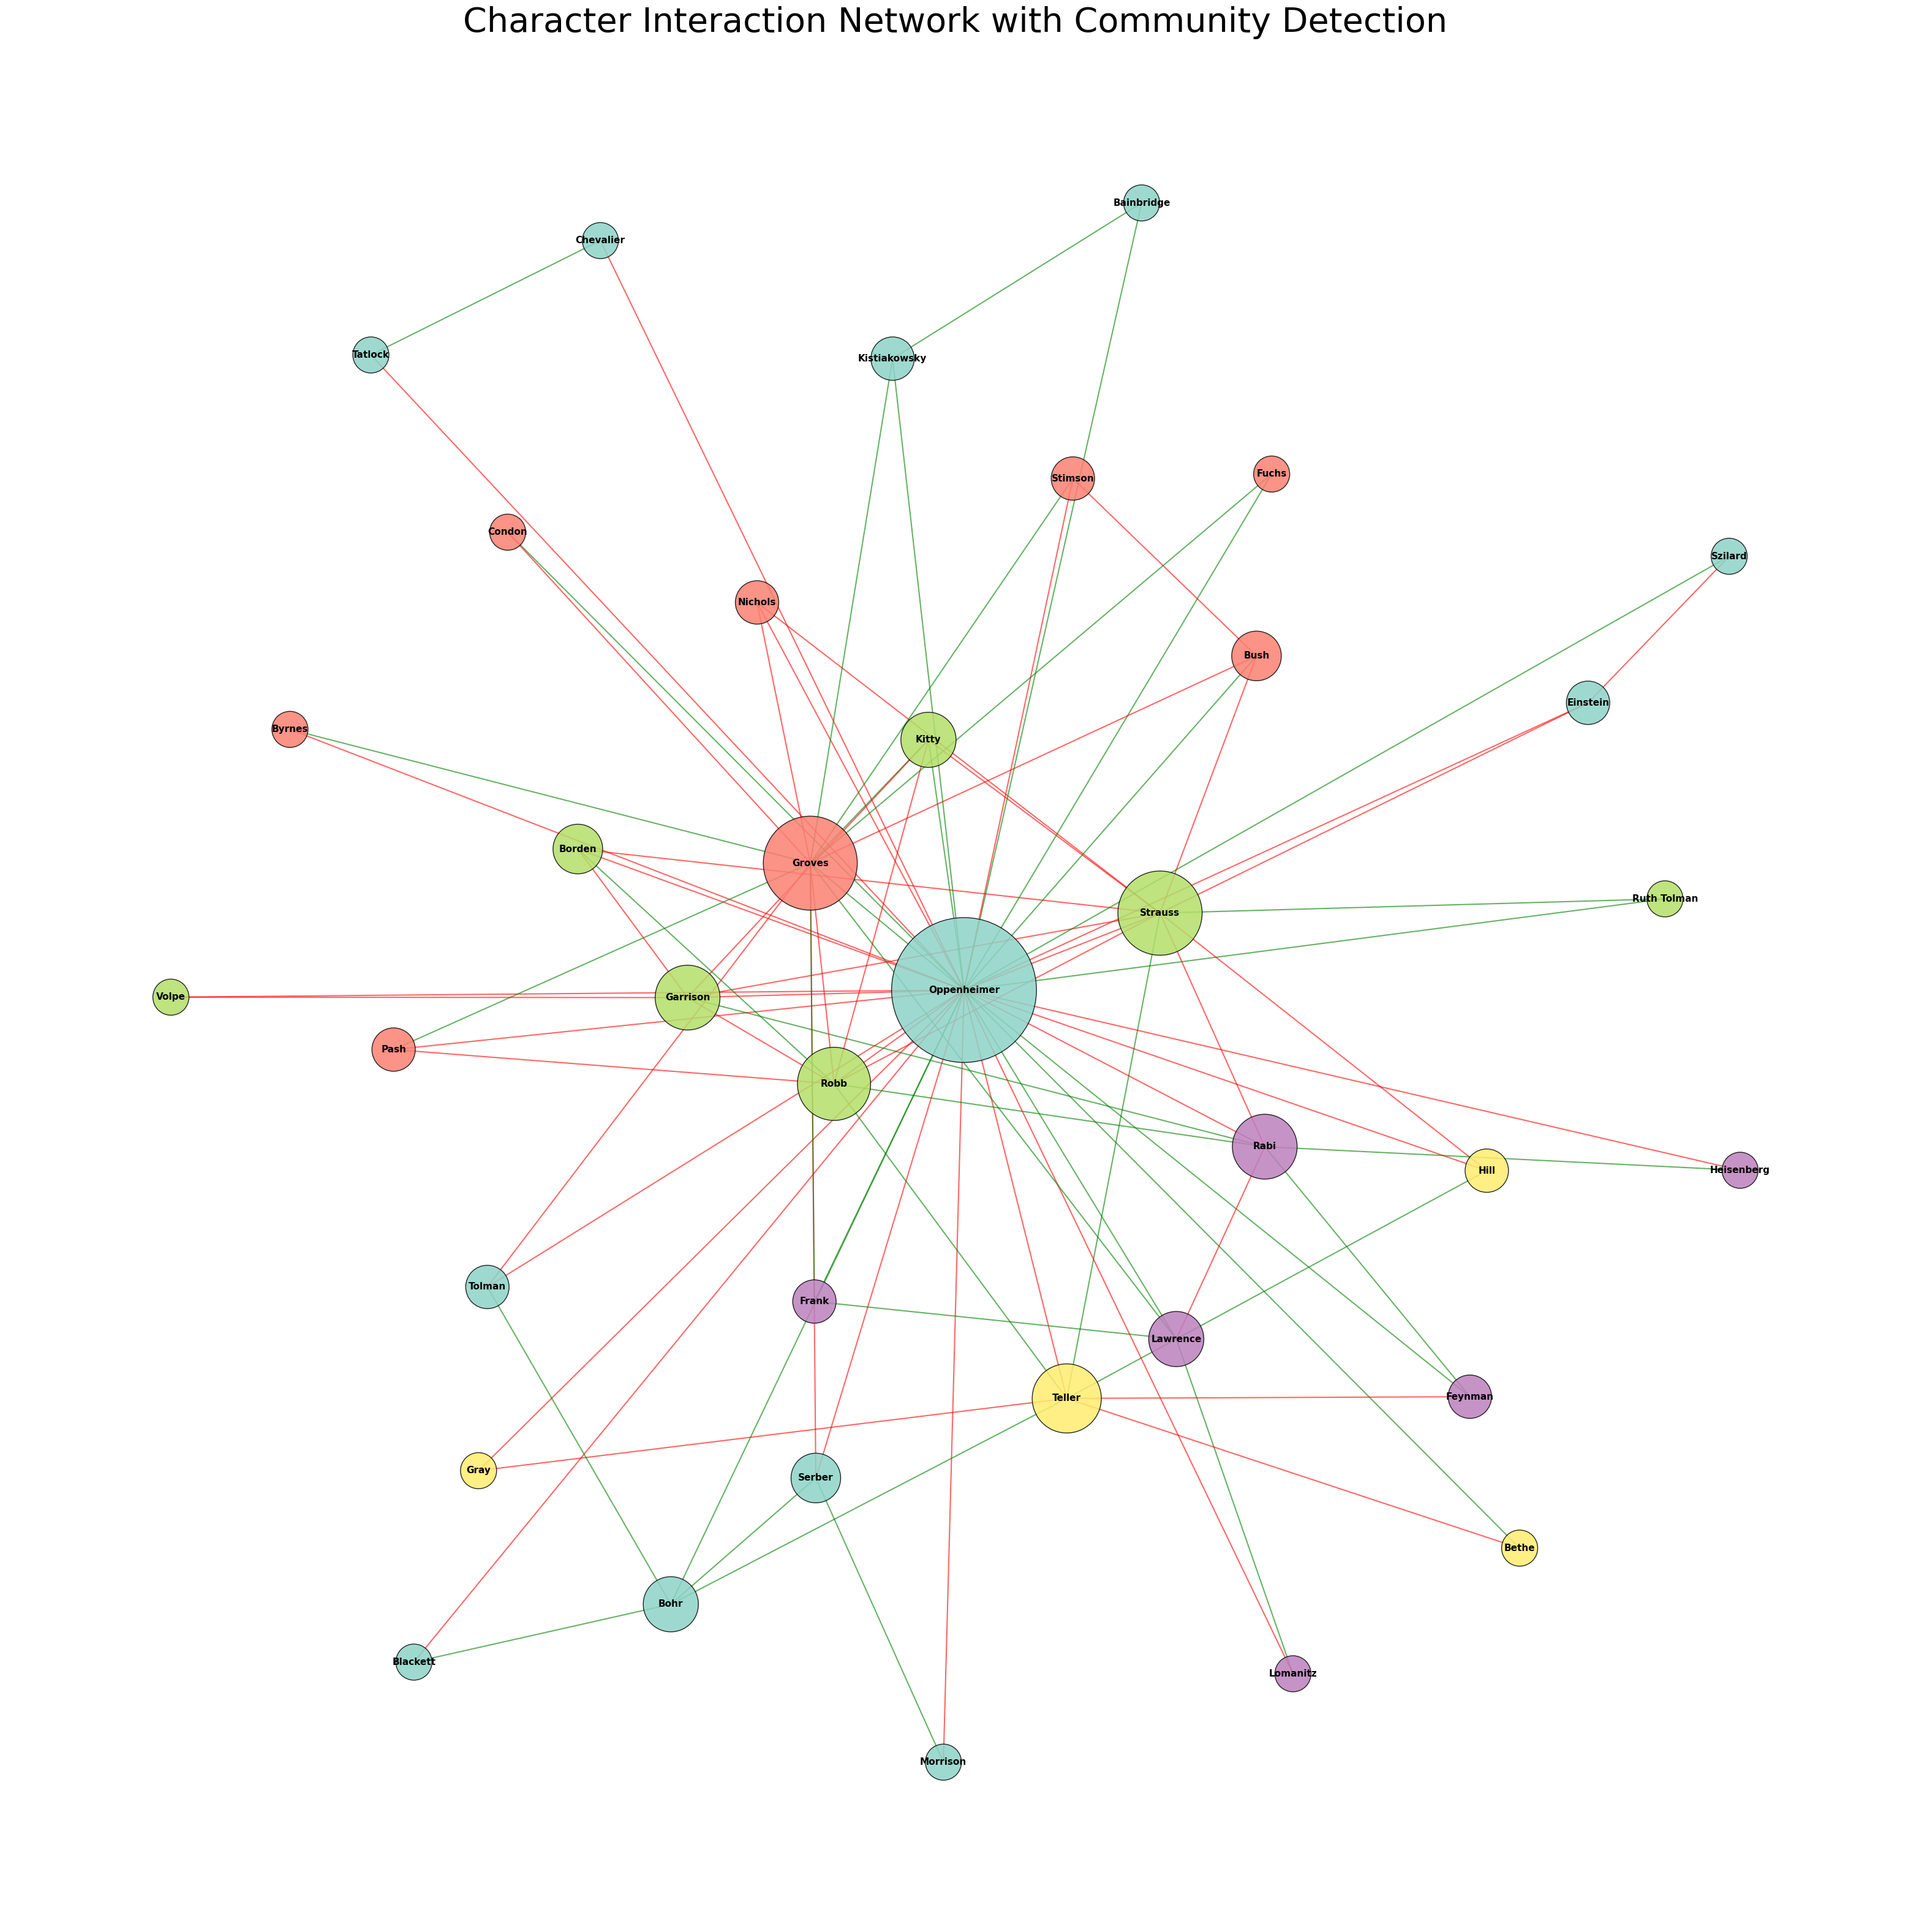

In [24]:
# Detect communities
communities = algorithms.louvain(G)

# Extract communities as a dictionary for each node
partition = {node: cid for cid, community in enumerate(communities.communities) for node in community}

# Map each node to its community color
community_colors = [partition[node] for node in G.nodes()]

# Plot the network with community coloring
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=community_colors, cmap=plt.cm.Set3, edgecolors='black', alpha=0.85)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

plt.title("Character Interaction Network with Community Detection", fontsize=40)
plt.axis("off")
plt.show()

In [25]:
# Standardize case for theme and type counts per community
for cid in set(partition.values()):
    # Filter edges within the current community
    community_edges = [
        (u, v, standardized_data) for u, v, standardized_data in G.edges(data=True) 
        if partition[u] == cid and partition[v] == cid
    ]

    # Count themes and relationship types with consistent case
    theme_counts = Counter(standardized_data['theme_type'].title() for _, _, standardized_data in community_edges if 'theme_type' in standardized_data)
    relationship_counts = Counter(standardized_data['type'].title() for _, _, standardized_data in community_edges if 'type' in standardized_data)
    sentiment_counts= Counter((standardized_data['sentiment'].title() for _, _, standardized_data in community_edges if 'sentiment' in standardized_data))
    place_counts=Counter((standardized_data['place'].title() for _, _, standardized_data in community_edges if 'place' in standardized_data))

    print(f"\nCommunity {cid} - Top Themes:", theme_counts.most_common(1))
    print(f"Community {cid} - Top Relationships:", relationship_counts.most_common(1))
    print(f"Community {cid} - Top Sentiment:", sentiment_counts.most_common(1))
    print(f"Community {cid} - Top Places:", place_counts.most_common(1))




Community 0 - Top Themes: [('Ambition And Power', 10)]
Community 0 - Top Relationships: [('Professional Mentorship', 7)]
Community 0 - Top Sentiment: [('Positive', 10)]
Community 0 - Top Places: []

Community 1 - Top Themes: [('Ambition And Power', 6)]
Community 1 - Top Relationships: [('Professional Mentorship', 5)]
Community 1 - Top Sentiment: [('Positive', 4)]
Community 1 - Top Places: []

Community 2 - Top Themes: [('Betrayal And Conflict', 5)]
Community 2 - Top Relationships: [('Professional Mentorship', 3)]
Community 2 - Top Sentiment: [('Negative', 8)]
Community 2 - Top Places: []

Community 3 - Top Themes: [('Friendship And Loyalty', 3)]
Community 3 - Top Relationships: [('Support', 2)]
Community 3 - Top Sentiment: [('Positive', 4)]
Community 3 - Top Places: []

Community 4 - Top Themes: [('Betrayal And Conflict', 1)]
Community 4 - Top Relationships: [('Personal Conflict', 1)]
Community 4 - Top Sentiment: [('Negative', 2)]
Community 4 - Top Places: []


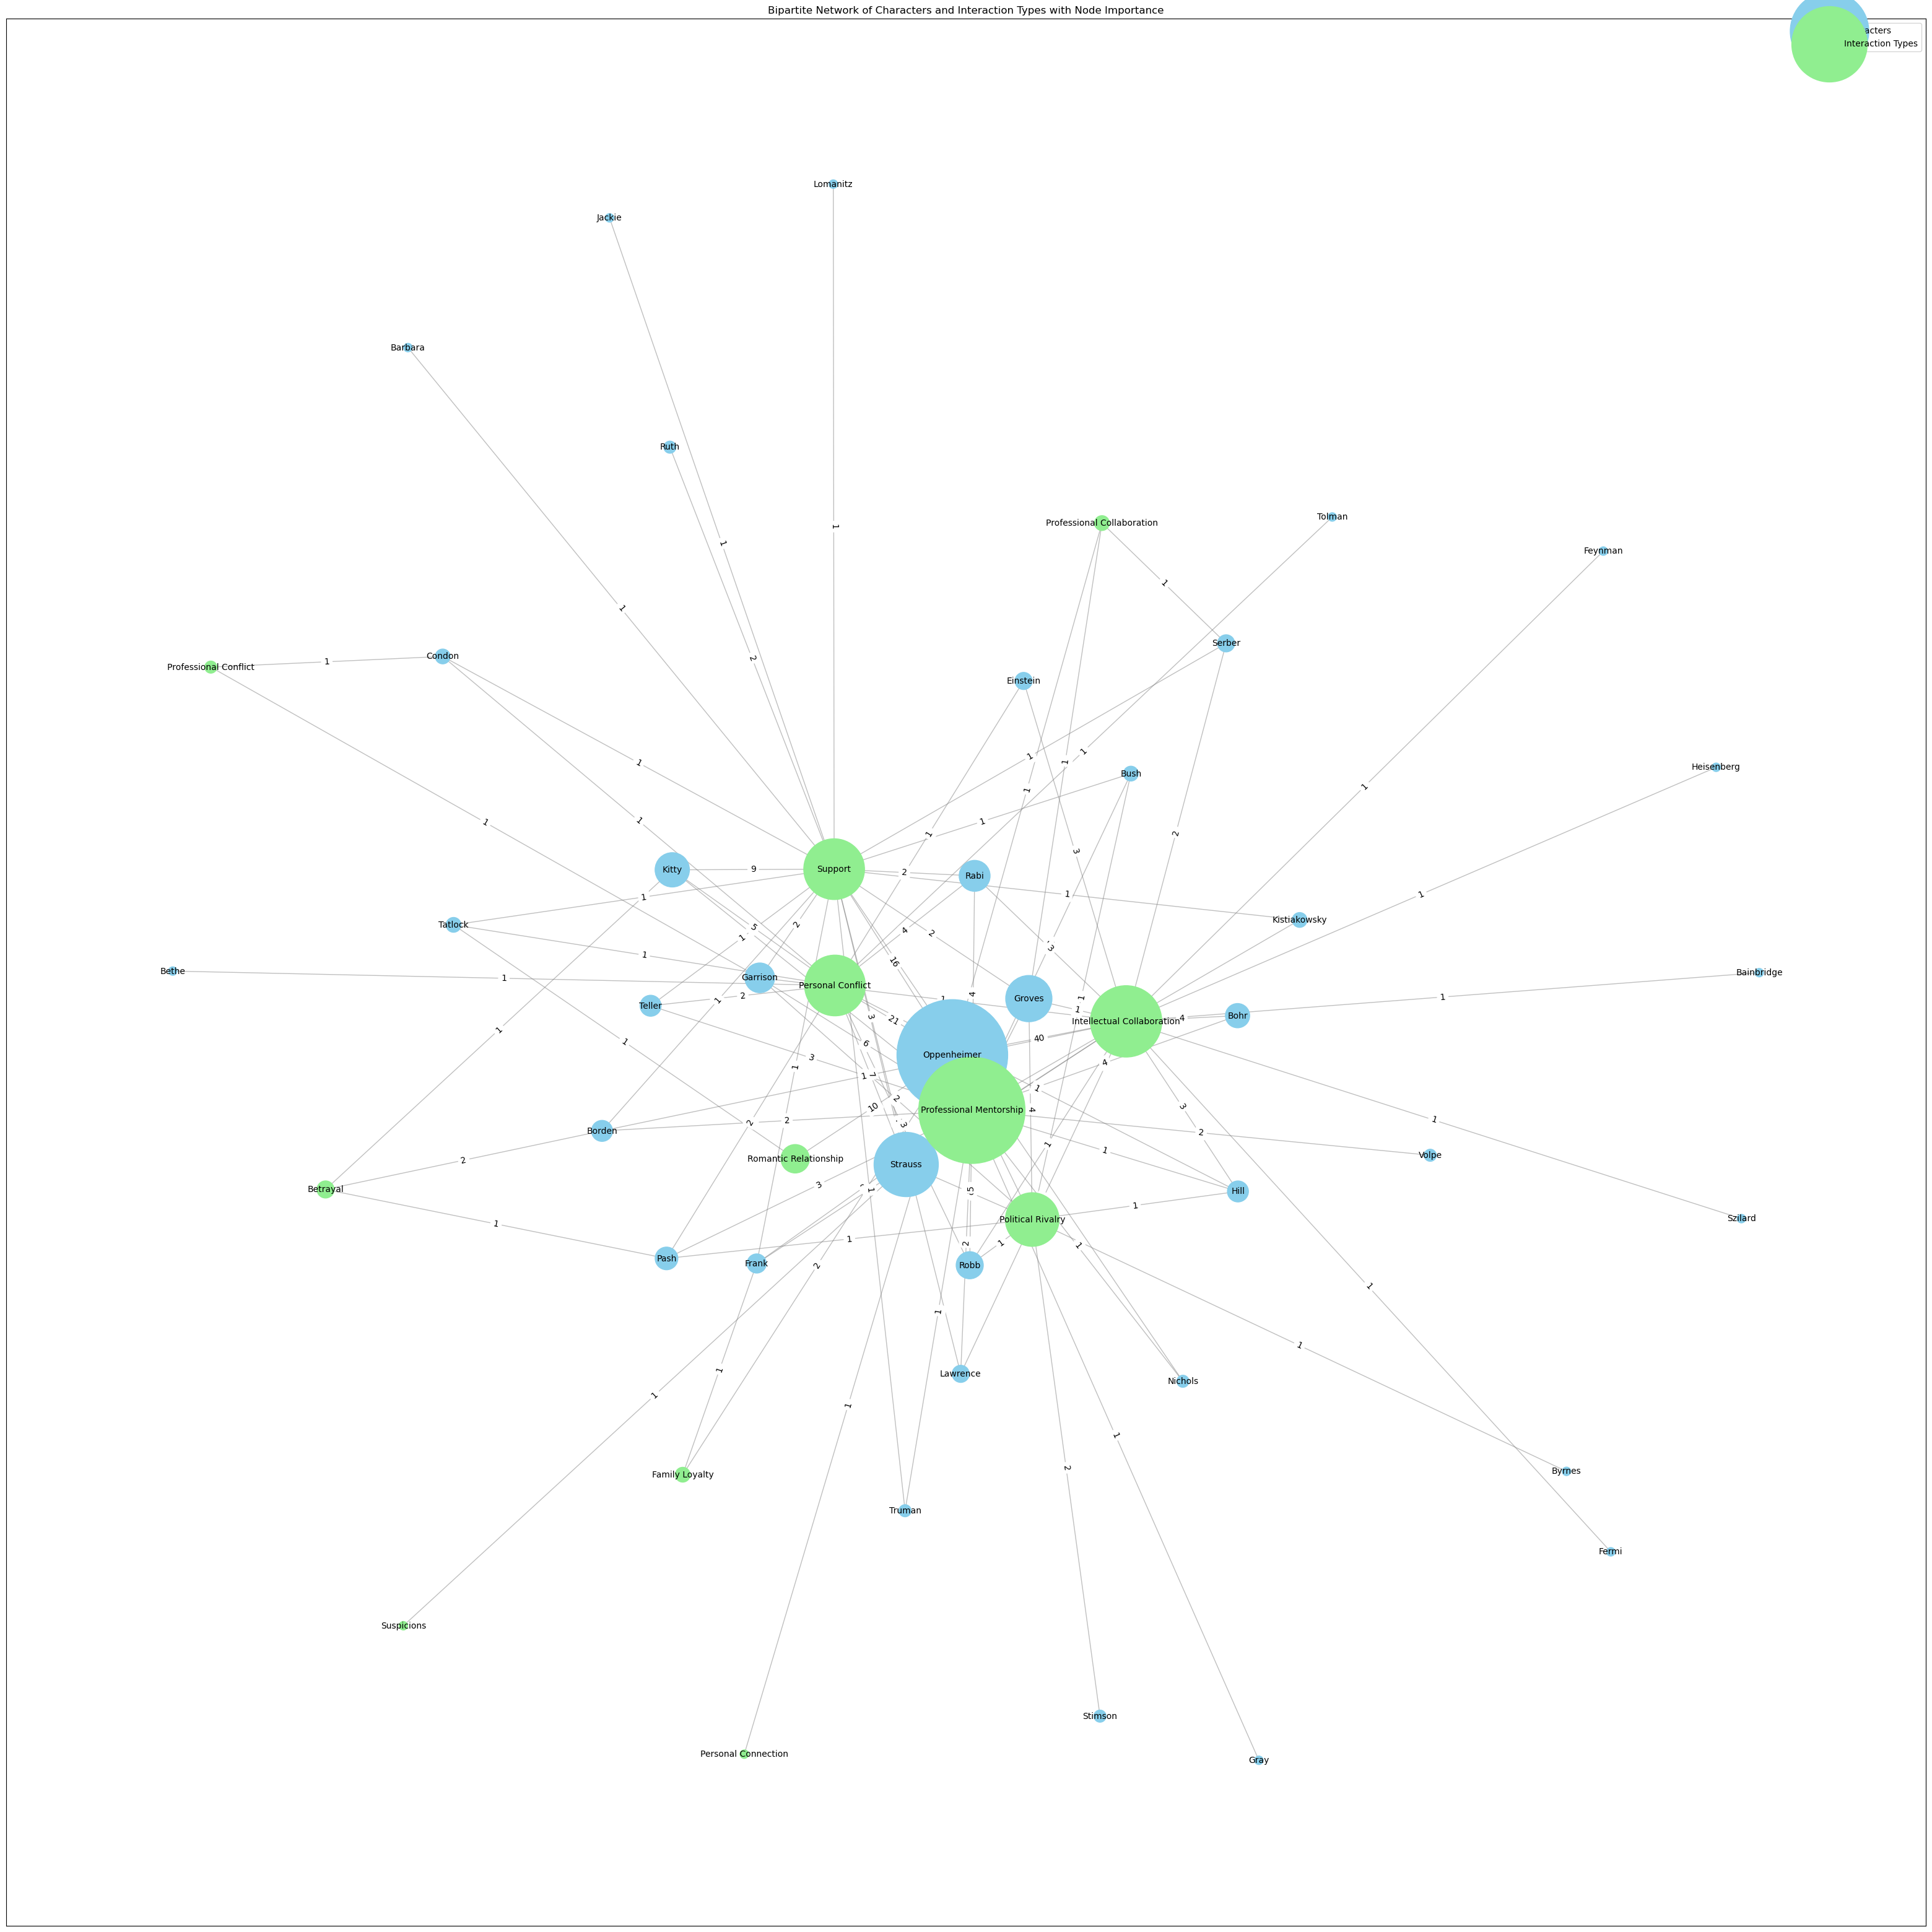

In [35]:
# Count interactions between each 'from' character and 'type' of interaction
interaction_counts = Counter((entry['from'], entry['type']) for entry in standardized_data)

# Calculate total interactions for each 'from' and 'type' node
from_totals = defaultdict(int)
type_totals = defaultdict(int)

for (from_char, interaction_type), count in interaction_counts.items():
    from_totals[from_char] += count
    type_totals[interaction_type] += count

# Create a bipartite graph
B = nx.Graph()

# Add 'from' characters as one set of nodes and 'type' as the other set with node size based on total interactions
for (from_char, interaction_type), count in interaction_counts.items():
    # Add character nodes to set 0 with node size proportional to total interactions
    B.add_node(from_char, bipartite=0, size=from_totals[from_char] * 100)  # Scale factor for visualization
    
    # Add interaction type nodes to set 1 with node size proportional to total interactions
    B.add_node(interaction_type, bipartite=1, size=type_totals[interaction_type] * 100)  # Scale factor for visualization
    
    # Add weighted edges based on interaction count
    B.add_edge(from_char, interaction_type, weight=count)

# Visualization
character_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
type_nodes = set(B) - character_nodes

# Positions for nodes using spring layout
pos = nx.spring_layout(B, k=0.5)
weights = nx.get_edge_attributes(B, 'weight')

plt.figure(figsize=(40, 40))

# Draw character nodes with sizes based on importance
character_sizes = [B.nodes[node]['size'] for node in character_nodes]
nx.draw_networkx_nodes(B, pos, nodelist=character_nodes, node_color="skyblue", node_size=character_sizes, label="Characters")

# Draw interaction type nodes with sizes based on importance
type_sizes = [B.nodes[node]['size'] for node in type_nodes]
nx.draw_networkx_nodes(B, pos, nodelist=type_nodes, node_color="lightgreen", node_size=type_sizes, label="Interaction Types")

# Draw edges and labels
nx.draw_networkx_edges(B, pos, width=1.0, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(B, pos, font_size=10)
nx.draw_networkx_edge_labels(B, pos, edge_labels=weights)

plt.title("Bipartite Network of Characters and Interaction Types with Node Importance")
plt.legend(loc="upper right")
plt.show()

In [57]:
import pandas as pd
import networkx as nx

# Calculate centralities
degree_centrality = nx.degree_centrality(B)
betweenness_centrality = nx.betweenness_centrality(B, weight='weight')
closeness_centrality = nx.closeness_centrality(B)

# Create a DataFrame to store centrality values
centralities_df = pd.DataFrame({
    'Node': degree_centrality.keys(),
    'Degree Centrality': degree_centrality.values(),
    'Betweenness Centrality': betweenness_centrality.values(),
    'Closeness Centrality': closeness_centrality.values(),
    'Node Type': ['Character' if node in character_nodes else 'Interaction Type' for node in degree_centrality.keys()],
    'Node Size': [B.nodes[node].get('size', 300) for node in degree_centrality.keys()]  # Display node sizes
})

# Display the DataFrame sorted by degree centrality
centralities_df = centralities_df.sort_values(by='Degree Centrality', ascending=False)

# Show the table
centralities_df


Node  Degree Centrality  Betweenness Centrality  \
6                      Support           0.437500                0.502407   
1      Professional Mentorship           0.416667                0.158054   
4   Intellectual Collaboration           0.375000                0.302466   
8            Personal Conflict           0.270833                0.135505   
2            Political Rivalry           0.208333                0.134390   
3                  Oppenheimer           0.187500                0.042553   
0                      Strauss           0.125000                0.041667   
45                    Garrison           0.104167                0.018532   
21                      Groves           0.104167                0.039179   
31                        Pash           0.083333                0.011466   
17                       Kitty           0.083333                0.008732   
30                        Robb           0.083333                0.049264   
19                      Borden           0.083333                0.059911   
11                       Frank           0.083333                0.077180   
7                         Rabi           0.083333                0.000000   
46                        Hill           0.083333                0.055985   
28                      Condon           0.062500                0.068500   
26                        Bush           0.062500                0.089451   
25  Professional Collaboration           0.062500                0.076931   
34                      Teller           0.062500                0.000000   
24                      Serber           0.062500                0.071439   
20                    Betrayal           0.062500                0.006229   
16                    Lawrence           0.062500                0.036203   
14                     Tatlock           0.062500                0.080347   
27                     Nichols           0.041667                0.021478   
41                      Truman           0.041667                0.021478   
12              Family Loyalty           0.041667                0.003743   
29       Professional Conflict           0.041667                0.007007   
15       Romantic Relationship           0.041667                0.000000   
5                         Bohr           0.041667                0.000000   
47                    Einstein           0.041667                0.001451   
37                Kistiakowsky           0.041667                0.000000   
39                  Bainbridge           0.020833                0.000000   
9                   Heisenberg           0.020833                0.000000   
44                       Volpe           0.020833                0.000000   
43                  Suspicions           0.020833                0.000000   
42                      Byrnes           0.020833                0.000000   
40                     Feynman           0.020833                0.000000   
35                     Szilard           0.020833                0.000000   
38                       Fermi           0.020833                0.000000   
36                     Stimson           0.020833                0.000000   
22                       Bethe           0.020833                0.000000   
10         Personal Connection           0.020833                0.000000   
33                      Tolman           0.020833                0.000000   
32                        Ruth           0.020833                0.000000   
13                      Jackie           0.020833                0.000000   
18                    Lomanitz           0.020833                0.000000   
23                     Barbara           0.020833                0.000000   
48                        Gray           0.020833                0.000000   

    Closeness Centrality         Node Type  Node Size  
6               0.527473  Interaction Type       5000  
1               0.516129  Interaction Type      15300  
4      

In [54]:
import pandas as pd

# Define the character of interest
focus_character = 'Oppenheimer'

# Extract the connections (neighbors) and edge weights for the focus character
connections = []
for neighbor in B.neighbors(focus_character):
    edge_weight = B[focus_character][neighbor]['weight']
    node_size = B.nodes[neighbor].get('size', 300)  # Default size if not defined
    connections.append({
        'Character': focus_character,
        'Connected Node': neighbor,
        'Weight': edge_weight,
        'Node Size': node_size
    })

# Convert to DataFrame for tabular display
connections_df = pd.DataFrame(connections)

# Sort by Weight in descending order
connections_df = connections_df.sort_values(by='Weight', ascending=False)

# Display the DataFrame
connections_df


Character              Connected Node  Weight  Node Size
0  Oppenheimer     Professional Mentorship      68      15300
1  Oppenheimer  Intellectual Collaboration      40       6900
5  Oppenheimer           Personal Conflict      21       5000
2  Oppenheimer                     Support      16       5000
6  Oppenheimer       Romantic Relationship      10       1100
3  Oppenheimer           Political Rivalry       7       3900
7  Oppenheimer              Family Loyalty       2        300
4  Oppenheimer         Personal Connection       1        100
8  Oppenheimer  Professional Collaboration       1        300

In [55]:
import pandas as pd

# Define the character of interest
focus_character = 'Strauss'

# Extract the connections (neighbors) and edge weights for the focus character
connections = []
for neighbor in B.neighbors(focus_character):
    edge_weight = B[focus_character][neighbor]['weight']
    node_size = B.nodes[neighbor].get('size', 300)  # Default size if not defined
    connections.append({
        'Character': focus_character,
        'Connected Node': neighbor,
        'Weight': edge_weight,
        'Node Size': node_size
    })

# Convert to DataFrame for tabular display
connections_df = pd.DataFrame(connections)

# Sort by Weight in descending order
connections_df = connections_df.sort_values(by='Weight', ascending=False)

# Display the DataFrame
connections_df


Character              Connected Node  Weight  Node Size
0   Strauss     Professional Mentorship      23      15300
1   Strauss           Political Rivalry      19       3900
3   Strauss           Personal Conflict       7       5000
2   Strauss  Intellectual Collaboration       3       6900
4   Strauss                     Support       3       5000
5   Strauss                  Suspicions       1        100

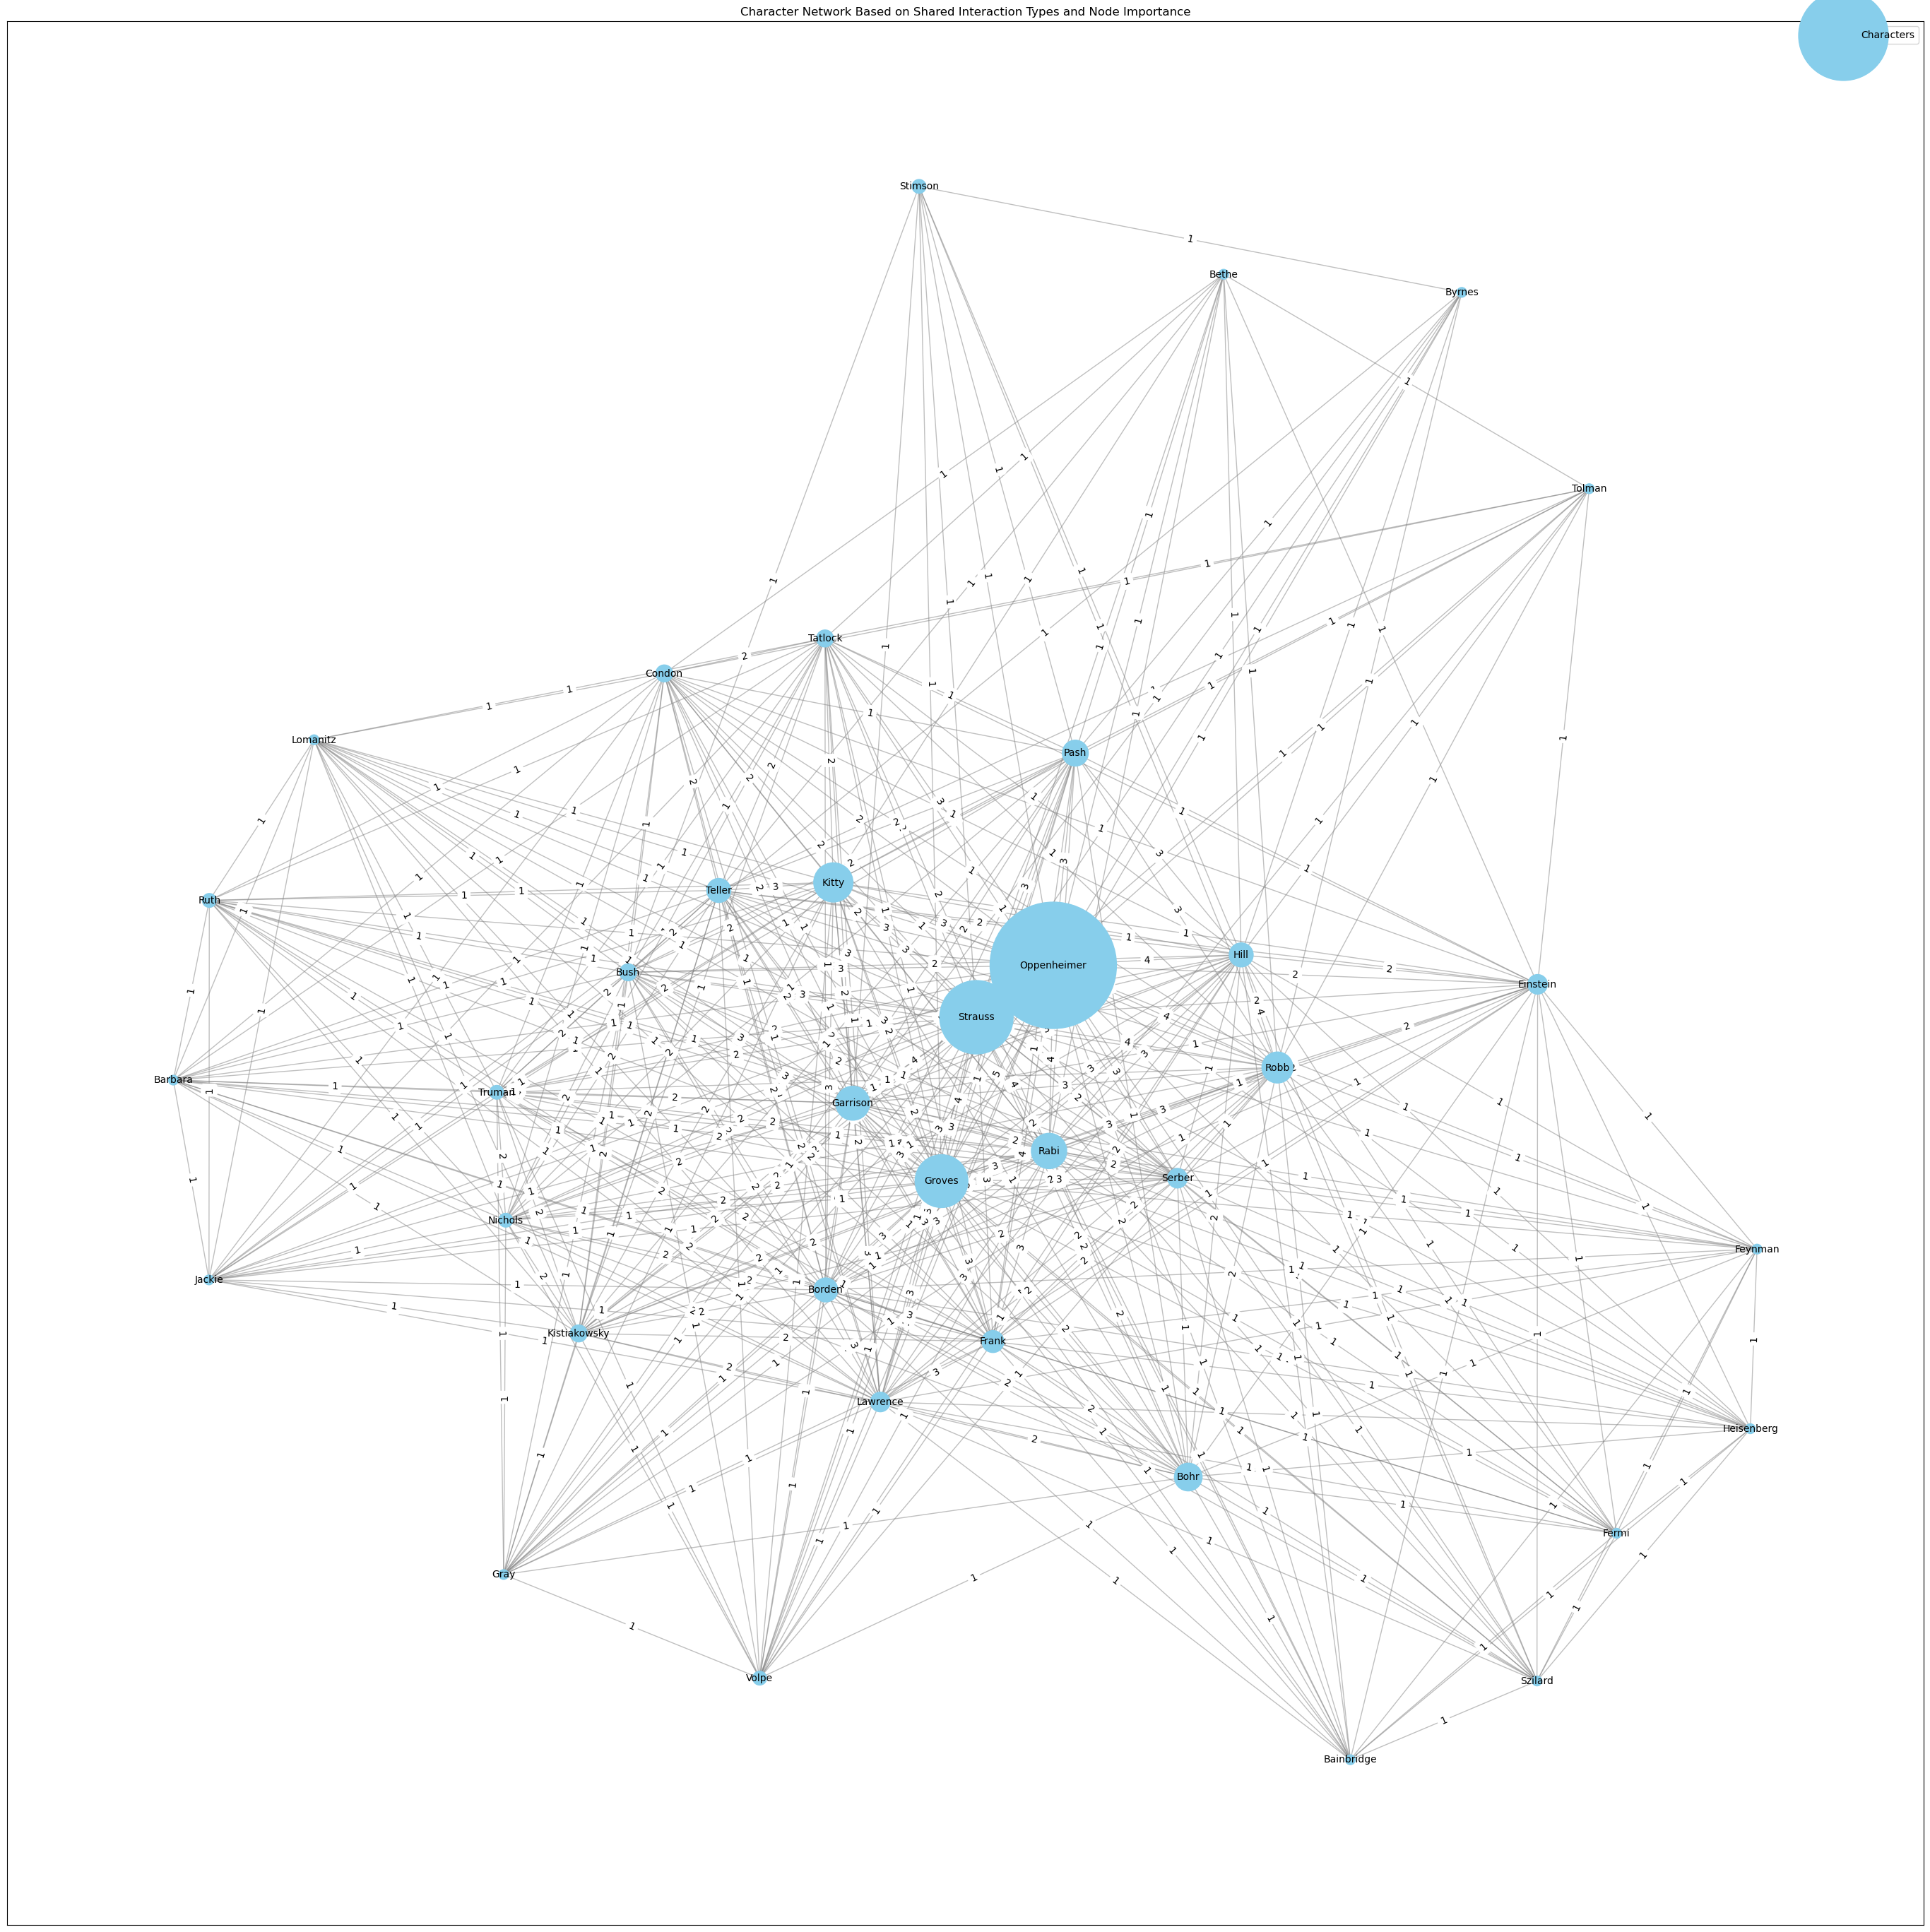

In [50]:
# Step 1: Create a mapping of characters to interaction types and count occurrences for each character
character_to_interactions = defaultdict(set)
character_counts = Counter()

for entry in standardized_data:
    character = entry['from']
    interaction_type = entry['type']
    character_to_interactions[character].add(interaction_type)
    character_counts[character] += 1  # Track the importance (frequency) of each character

# Step 2: Create a new graph where nodes are characters, and edges indicate shared interaction types
character_graph = nx.Graph()

# Step 3: Add nodes with sizes based on importance and weighted edges based on shared interaction types
for char1, interactions1 in character_to_interactions.items():
    # Add character nodes with size proportional to their importance
    character_graph.add_node(char1, size=character_counts[char1] * 100)  # Adjust scaling factor as needed
    
    for char2, interactions2 in character_to_interactions.items():
        if char1 != char2:
            # Find the number of shared interaction types
            shared_interactions = interactions1.intersection(interactions2)
            shared_count = len(shared_interactions)
            
            # Add an edge only if there is at least one shared interaction type
            if shared_count > 0:
                character_graph.add_edge(char1, char2, weight=shared_count)

# Visualization
pos = nx.spring_layout(character_graph, k=0.5)  # Positions for all nodes
weights = nx.get_edge_attributes(character_graph, 'weight')

plt.figure(figsize=(35, 35))

# Draw nodes with sizes based on importance (frequency of interactions)
node_sizes = [character_graph.nodes[node]['size'] for node in character_graph.nodes]
nx.draw_networkx_nodes(character_graph, pos, node_color="skyblue", node_size=node_sizes, label="Characters")

# Draw edges with weights
nx.draw_networkx_edges(character_graph, pos, width=1.0, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(character_graph, pos, font_size=10)
nx.draw_networkx_edge_labels(character_graph, pos, edge_labels=weights)

plt.title("Character Network Based on Shared Interaction Types and Node Importance")
plt.legend(loc="upper right")
plt.show()

In [56]:
import pandas as pd
import networkx as nx

# Calculate centralities for the character network
degree_centrality = nx.degree_centrality(character_graph)
betweenness_centrality = nx.betweenness_centrality(character_graph, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(character_graph, max_iter=1000)

# Create a DataFrame to store centrality values
centralities_df = pd.DataFrame({
    'Character': degree_centrality.keys(),
    'Degree Centrality': degree_centrality.values(),
    'Betweenness Centrality': betweenness_centrality.values(),
    'Eigenvector Centrality': eigenvector_centrality.values(),
    'Node Size': [character_graph.nodes[character].get('size', 300) for character in degree_centrality.keys()]  # Display node sizes
})

# Display the DataFrame sorted by degree centrality
centralities_df = centralities_df.sort_values(by='Degree Centrality', ascending=False)

# Show the table
centralities_df


Character  Degree Centrality  Betweenness Centrality  \
0        Strauss           1.000000                0.020178   
1    Oppenheimer           1.000000                0.020178   
3           Rabi           0.944444                0.011131   
33      Garrison           0.944444                0.017370   
12        Groves           0.944444                0.019403   
19          Robb           0.888889                0.027882   
11        Borden           0.888889                0.009371   
8       Lawrence           0.888889                0.012263   
5          Frank           0.888889                0.012263   
34          Hill           0.888889                0.027882   
9          Kitty           0.805556                0.007009   
23        Teller           0.805556                0.007009   
15        Serber           0.805556                0.031609   
16          Bush           0.777778                0.011981   
26  Kistiakowsky           0.722222                0.007150   
30        Truman           0.722222                0.007150   
20          Pash           0.722222                0.025707   
18        Condon           0.722222                0.022499   
17       Nichols           0.722222                0.007150   
2           Bohr           0.722222                0.024152   
7        Tatlock           0.722222                0.026044   
35      Einstein           0.666667                0.026456   
14       Barbara           0.555556                0.019735   
21          Ruth           0.555556                0.019735   
10      Lomanitz           0.555556                0.019735   
6         Jackie           0.555556                0.019735   
32         Volpe           0.527778                0.024976   
36          Gray           0.527778                0.024976   
28    Bainbridge           0.472222                0.010338   
29       Feynman           0.472222                0.010338   
24       Szilard           0.472222                0.010338   
4     Heisenberg           0.472222                0.010338   
27         Fermi           0.472222                0.010338   
22        Tolman           0.333333                0.009197   
13         Bethe           0.333333                0.009197   
25       Stimson           0.250000                0.004547   
31        Byrnes           0.250000                0.004547   

    Eigenvector Centrality  Node Size  
0                 0.214355       5600  
1                 0.214355      16600  
3                 0.209802       1300  
33                0.208399       1200  
12                0.208399       2900  
19                0.193777       1000  
11                0.203847        600  
8                 0.203847        400  
5                 0.203847        500  
34                0.193777        600  
9                 0.188852       1600  
23                0.188852        600  
15                0.187755        400  
16                0.181855        300  
26                0.177302        300  
30                0.177302        200  
20                0.165967        700  
18                0.172588        300  
17                0.177302        200  
2                 0.170659        800  
7                 0.172588        300  
35                0.153120        400  
14                0.140817        100  
21                0.140817        200  
10                0.140817        100  
6                 0.140817        100  
32                0.137255        200  
36                0.137255        100  
28                0.114692        100  
29                0.114692        100  
24                0.114692        100  
4                 0.114692        100  
27                0.114692        100  
22                0.081507        100  
13                0.081507        100  
25                0.062307        200  
31                0.062307        100

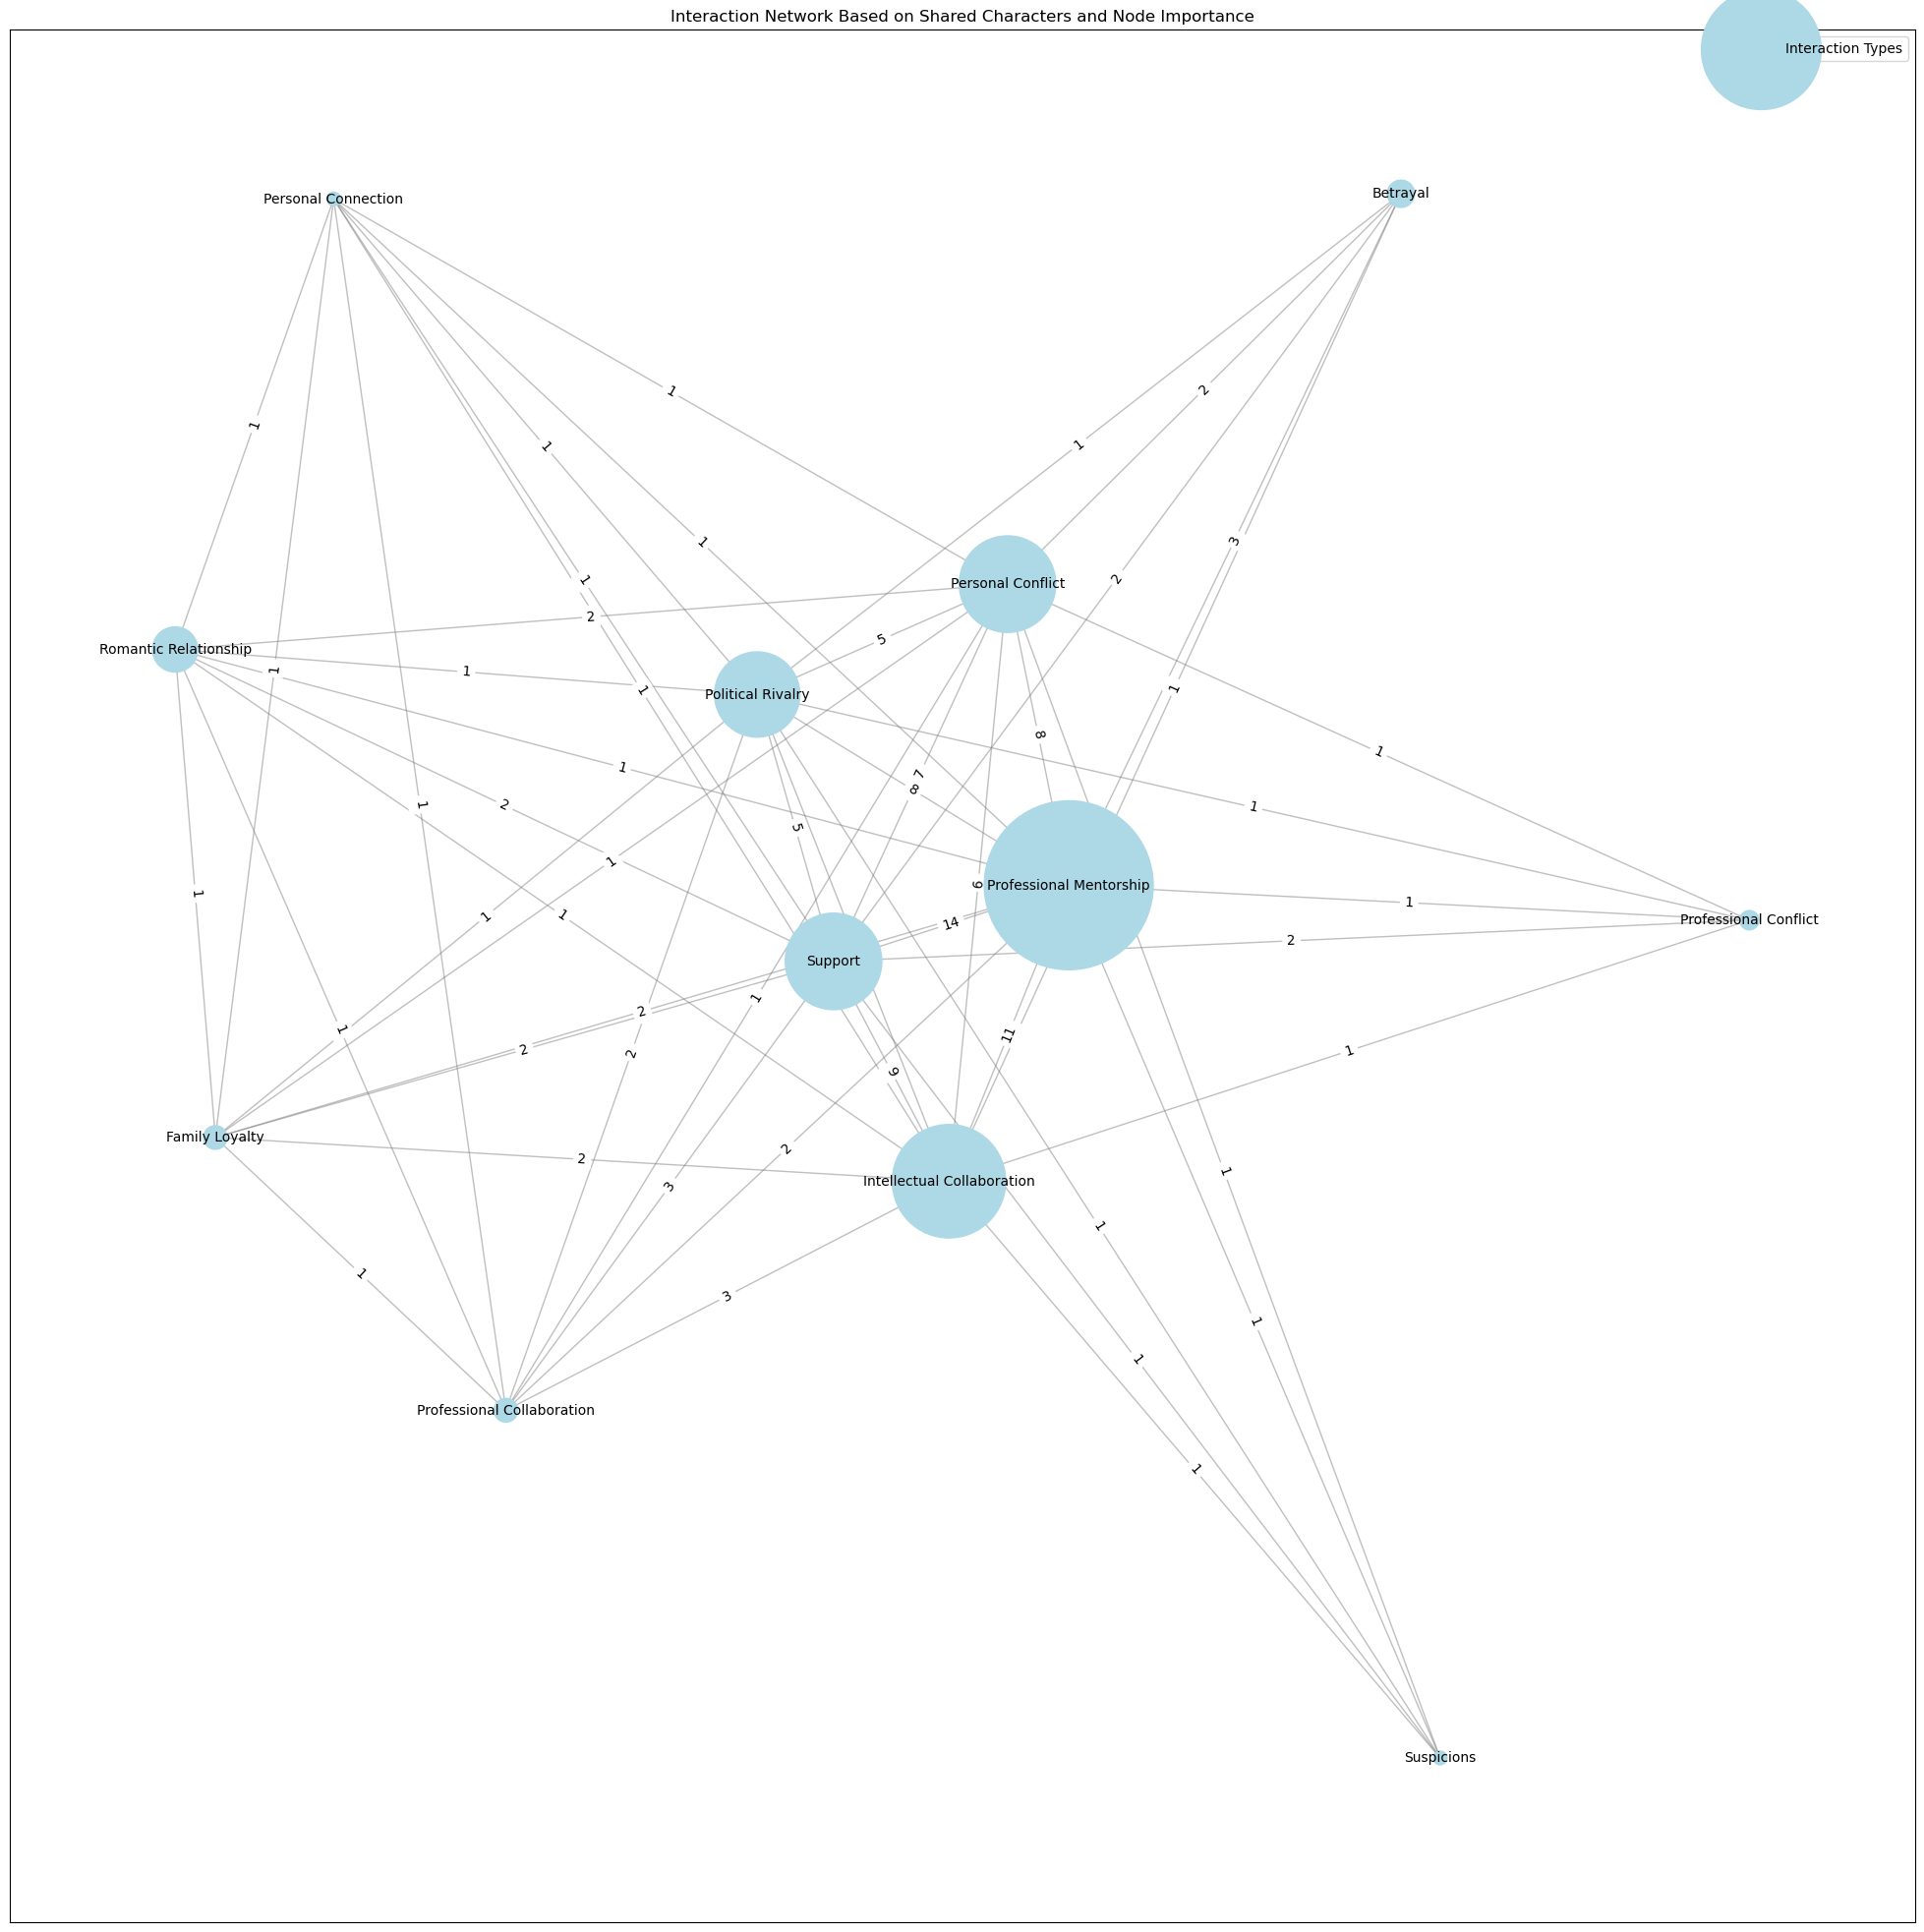

In [51]:
interaction_to_characters = defaultdict(set)
interaction_counts = Counter()

for entry in standardized_data:
    interaction_type = entry['type']
    character = entry['from']
    interaction_to_characters[interaction_type].add(character)
    interaction_counts[interaction_type] += 1

# Step 2: Create a new graph where nodes are interaction types, and edges indicate shared characters
interaction_graph = nx.Graph()

# Step 3: Add nodes with sizes based on the importance (frequency of occurrences) and weighted edges based on shared characters
for interaction1, characters1 in interaction_to_characters.items():
    # Add node for each interaction with size proportional to its importance
    interaction_graph.add_node(interaction1, size=interaction_counts[interaction1] * 100)  # Adjust scaling factor as needed

    for interaction2, characters2 in interaction_to_characters.items():
        if interaction1 != interaction2:
            # Find the number of shared characters
            shared_characters = characters1.intersection(characters2)
            shared_count = len(shared_characters)
            
            # Add an edge only if there is at least one shared character
            if shared_count > 0:
                interaction_graph.add_edge(interaction1, interaction2, weight=shared_count)

# Visualization
pos = nx.spring_layout(interaction_graph, k=0.5)  # Positions for all nodes
weights = nx.get_edge_attributes(interaction_graph, 'weight')

plt.figure(figsize=(25, 25))

# Draw nodes with sizes based on importance (frequency of occurrence)
node_sizes = [interaction_graph.nodes[node]['size'] for node in interaction_graph.nodes]
nx.draw_networkx_nodes(interaction_graph, pos, node_color="lightblue", node_size=node_sizes, label="Interaction Types")

# Draw edges with weights
nx.draw_networkx_edges(interaction_graph, pos, width=1.0, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(interaction_graph, pos, font_size=10)
nx.draw_networkx_edge_labels(interaction_graph, pos, edge_labels=weights)

plt.title("Interaction Network Based on Shared Characters and Node Importance")
plt.legend(loc="upper right")
plt.show()

In [58]:
import pandas as pd
import networkx as nx

# Calculate centralities for the interaction network
degree_centrality = nx.degree_centrality(interaction_graph)
betweenness_centrality = nx.betweenness_centrality(interaction_graph, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(interaction_graph, max_iter=1000)

# Create a DataFrame to store centrality values
centralities_df = pd.DataFrame({
    'Interaction Type': degree_centrality.keys(),
    'Degree Centrality': degree_centrality.values(),
    'Betweenness Centrality': betweenness_centrality.values(),
    'Eigenvector Centrality': eigenvector_centrality.values(),
    'Node Size': [interaction_graph.nodes[interaction].get('size', 300) for interaction in degree_centrality.keys()]  # Display node sizes
})

# Display the DataFrame sorted by degree centrality
centralities_df = centralities_df.sort_values(by='Degree Centrality', ascending=False)

# Show the table
centralities_df


Interaction Type  Degree Centrality  Betweenness Centrality  \
0      Professional Mentorship           1.000000                0.024848   
1            Political Rivalry           1.000000                0.116046   
2   Intellectual Collaboration           1.000000                0.074488   
3                      Support           1.000000                0.003636   
4            Personal Conflict           1.000000                0.069870   
5          Personal Connection           0.727273                0.147720   
6               Family Loyalty           0.727273                0.016234   
7        Romantic Relationship           0.727273                0.053781   
9   Professional Collaboration           0.727273                0.004545   
8                     Betrayal           0.454545                0.003636   
10       Professional Conflict           0.454545                0.033434   
11                  Suspicions           0.454545                0.069798   

    Eigenvector Centrality  Node Size  
0                 0.338960      15300  
1                 0.338960       3900  
2                 0.338960       6900  
3                 0.338960       5000  
4                 0.338960       5000  
5                 0.282466        100  
6                 0.282466        300  
7                 0.282466       1100  
9                 0.282466        300  
8                 0.188311        400  
10                0.188311        200  
11                0.188311        100